In [1]:
## CNN para previsão de fraturas

**Acerca do Dataset**
- Este conjunto de dados é composto por imagens de raios X fraturadas e não fraturadas de várias articulações. A tarefa é construir um classificador de imagens para detectar fraturas em determinada imagem de raio-X. Este conjunto de dados é composto por diferentes articulações nas extremidades superiores. O isolamento de articulações individuais é recomendado para melhorar o desempenho dos classificadores.
- 8863 instâncias para treino
- 600 instâncias para teste

### Imports

In [2]:
!pip install livelossplot

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from livelossplot import PlotLosses

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

from torchvision.datasets import ImageFolder

from torchvision.models import resnet50, ResNet50_Weights

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Resize

### 0. Preparar o Setup

In [4]:
PATH_TRAIN = '/kaggle/input/bone-fracture-detection-using-xrays/archive (6)/train'
PATH_TEST = '/kaggle/input/bone-fracture-detection-using-xrays/archive (6)/val'

BATCH_SIZE = 32

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


### 1. Preparar os dados

In [6]:
transform = Compose(
        [ToTensor(),
         Resize((224, 224),antialias=True),
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])

In [7]:
# Definir a seed

seed = 2024

torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Importar dataset
train_dataset = ImageFolder(PATH_TRAIN, transform=transform)
test_dataset = ImageFolder(PATH_TEST, transform=transform)

validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

### 2. Definir o Modelo

In [8]:
M_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

num_classes = len(train_dataset.classes)
M_resnet.fc = torch.nn.Linear(M_resnet.fc.in_features, num_classes) # alteração na camada de saída

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


In [9]:
M_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# função de perda e otimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(M_resnet.parameters(), lr=0.005, momentum=0.9)

### 3. Treinar o Modelo

In [11]:
EPOCHS = 15

def train_model(train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float()/len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()

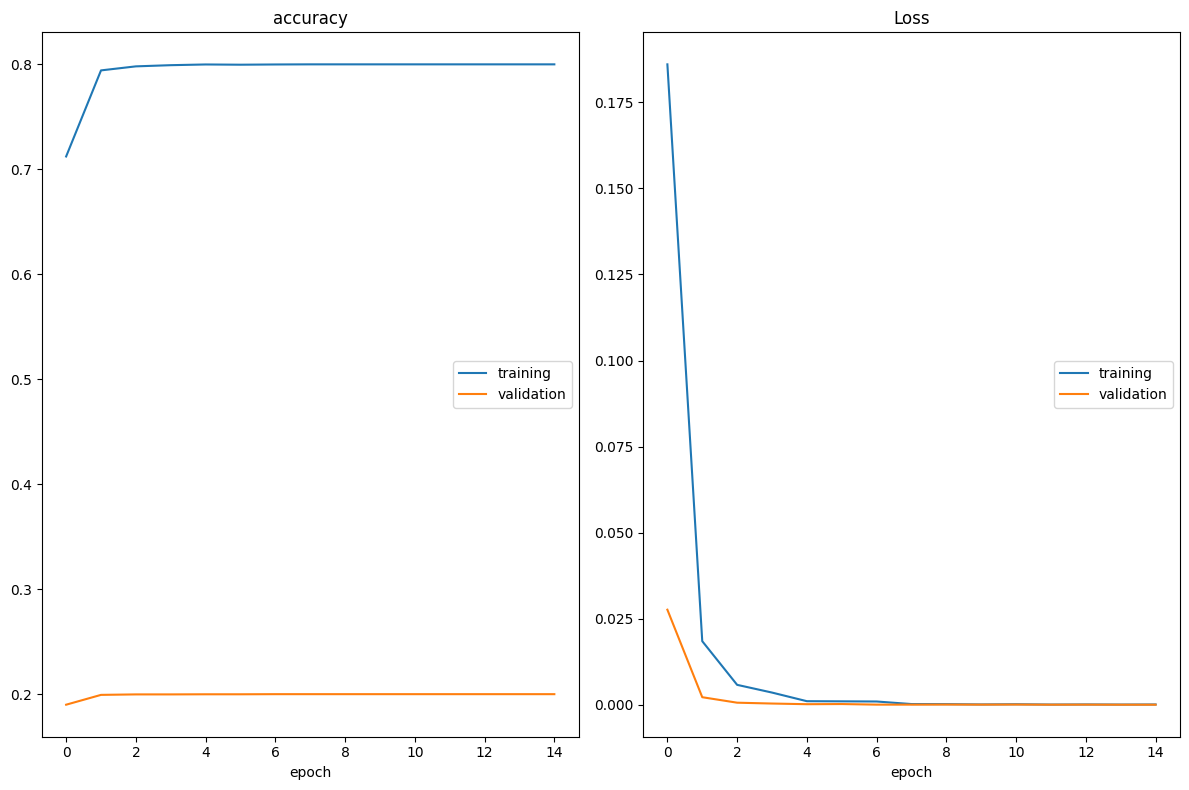

accuracy
	training         	 (min:    0.712, max:    0.800, cur:    0.800)
	validation       	 (min:    0.190, max:    0.200, cur:    0.200)
Loss
	training         	 (min:    0.000, max:    0.186, cur:    0.000)
	validation       	 (min:    0.000, max:    0.028, cur:    0.000)

Training completed in 697.2594375610352 seconds


In [12]:
start_time = time.time()

train_model(train_loader, val_loader, M_resnet, criterion, optimizer)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time} seconds")

### 4. Avaliar o modelo

In [13]:
def logits_to_probabilities(logits):
    # logits é uma matriz de formato (n_samples, n_classes)
    # onde n_samples é o número de amostras e n_classes é o número de classes
    exp_logits = np.exp(logits)  # Aplicar exponencial a cada elemento dos logits
    probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probabilities

def write_probabilities_to_csv(probabilities, filename):
    np.savetxt(filename, probabilities, delimiter=',', fmt='%.6f')

def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    device = next(model.parameters()).device
    
    model.eval()  # Garantir que o modelo está no modo de avaliação
    
    with torch.no_grad():  # Desativar o cálculo de gradientes durante a avaliação
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            yprev = model(inputs)
            yprev = yprev.detach().cpu().numpy()
            actual = labels.cpu().numpy()
            
            probabilities = logits_to_probabilities(yprev)
            write_probabilities_to_csv(probabilities, '/kaggle/working/probabilities.csv')
            
            yprev = np.argmax(yprev, axis=1)
            actual = actual.reshape((len(actual), 1))
            yprev = yprev.reshape((len(yprev), 1))
            predictions.append(yprev)
            actual_values.append(actual)
            
    predictions = np.vstack(predictions)
    actual_values = np.vstack(actual_values)
    
    return actual_values, predictions

In [14]:
def display_predictions(actual_values, predictions):
    acertou = 0
    falhou = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'real:{r} previsão:{p}')
            primeiros += 1
        if r == p:
            acertou += 1
        else:
            falhou += 1
    
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

In [15]:
def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes, annot_kws={"size": 12},
                fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
actual_values, predictions = evaluate_model(test_loader, M_resnet)
display_predictions(actual_values, predictions)

real:[1] previsão:[0]
real:[0] previsão:[0]
real:[1] previsão:[1]
real:[0] previsão:[0]
real:[1] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[1] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[1] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
Accuracy: 0.687

acertou:412 falhou:188


In [17]:
print(classification_report(actual_values, predictions))

              precision    recall  f1-score   support

           0       0.69      0.87      0.77       360
           1       0.68      0.41      0.51       240

    accuracy                           0.69       600
   macro avg       0.68      0.64      0.64       600
weighted avg       0.68      0.69      0.67       600



In [18]:
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=['fratured', 'not fractured']
cm = confusion_matrix(actual_values, predictions)
print (cm)

[[313  47]
 [141  99]]


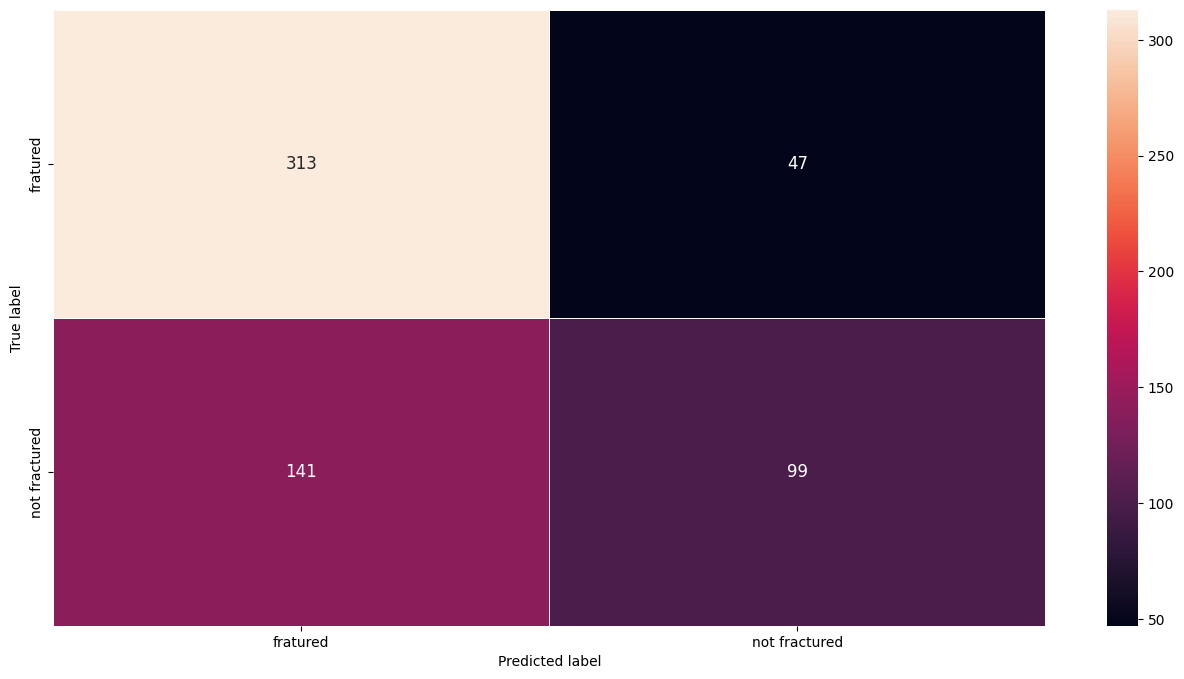

In [19]:
display_confusion_matrix(cm,list_classes)

### 5. Guardar o Modelo

In [21]:
torch.save(M_resnet.state_dict(), '/kaggle/working/model_resnet50.pth')

!ls /kaggle/working

model_resnet50.pth  probabilities.csv
